In [1]:

import torch
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import numpy as np
import sys
import copy
sys.path.append('../')

from models import (
    AE,
    IRAE    
)

from models.modules import (
    FC_vec,
)

from bezier import Bezier, demo2bezier, bezier2traj, bezier_Riemannian_metric

from utils.utils import label_to_color
from sklearn.mixture import GaussianMixture

device = f'cuda:0'   

seed = 2023
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

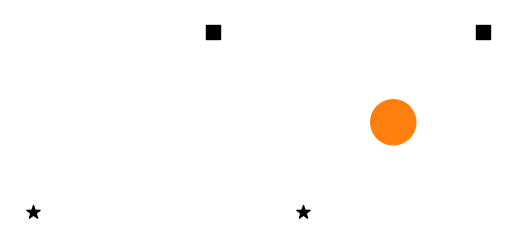

In [2]:
# Env setting
workspace = [[-1, 1], [-1, 1]]
init = [0.8, 0.8]
goal = [-0.8, -0.8]

fig, axs = plt.subplots(1, 2)
for i in range(2):
    axs[i].set_xlim(workspace[0])
    axs[i].set_ylim(workspace[1])
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].scatter(init[0], init[1], marker='s', s=100, c='k')
    axs[i].scatter(goal[0], goal[1], marker='*', s=100, c='k')
    if i == 1:
        Obs = Circle(xy=[0,0], radius=0.2, color='tab:orange')
        axs[i].add_patch(Obs)
plt.show()

In [3]:
# EXP 1
trajs1 = [
    np.load('../datasets/poc/class1_4.npy'),
    np.load('../datasets/poc/class1_2.npy'),
    np.load('../datasets/poc/class1_1.npy'),
    np.load('../datasets/poc/class1.npy'),
]
trajs2 = [
    np.load('../datasets/poc/class2_4.npy'),
    np.load('../datasets/poc/class2_2.npy'),
    np.load('../datasets/poc/class2_3.npy'),
    np.load('../datasets/poc/class2.npy'),
]

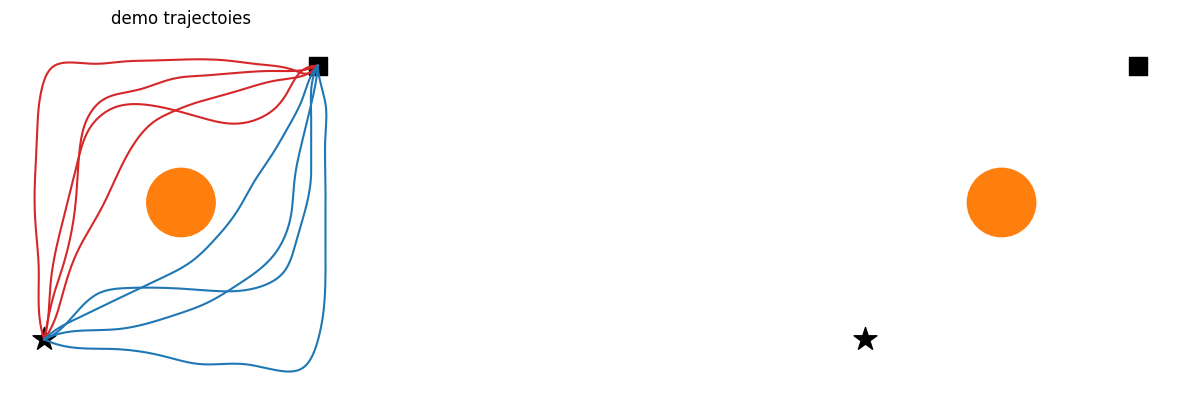

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in [0, 2]:
    axs[i].set_xlim(workspace[0])
    axs[i].set_ylim(workspace[1])
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].scatter(init[0], init[1], marker='s', s=150, c='k')
    axs[i].scatter(goal[0], goal[1], marker='*', s=300, c='k')
    Obs = Circle(xy=[0,0], radius=0.2, color='tab:orange')
    axs[i].add_patch(Obs)
    
    if i == 0:
        for traj in trajs1:
            axs[i].plot(traj[0, :, 0], traj[0, :, 1], c='tab:red')
        
        for traj in trajs2:
            axs[i].plot(traj[0, :, 0], traj[0, :, 1], c='tab:blue')
        
axs[1].axis('off')

axs[0].set_title('demo trajectoies')
plt.show()

In [5]:
trajs_class1 = torch.cat([torch.tensor(traj[0], dtype=torch.float32).unsqueeze(0) for traj in trajs1], dim=0)
trajs_class2 = torch.cat([torch.tensor(traj[0], dtype=torch.float32).unsqueeze(0) for traj in trajs2], dim=0)

In [6]:
trajs = torch.cat([trajs_class1, trajs_class2], dim=0)
targets = torch.tensor([0, 0, 0, 0, 1, 1, 1, 1])

In [7]:
num_control_points = 10

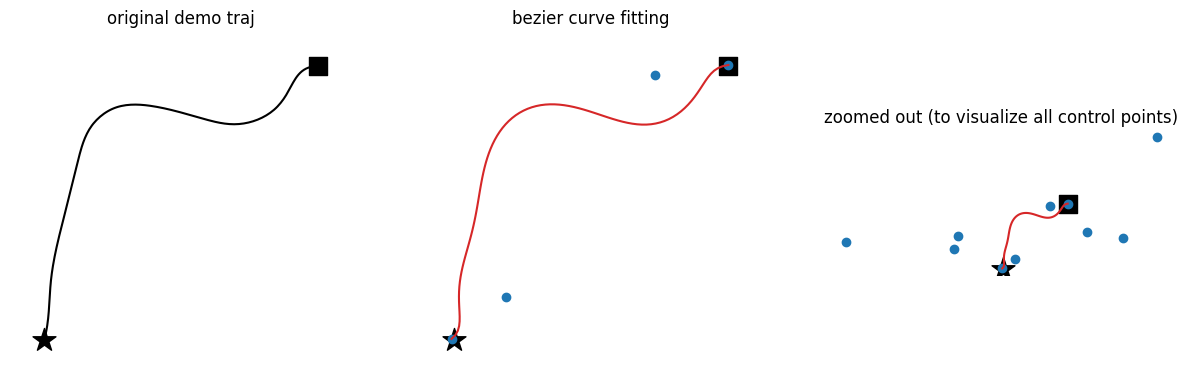

In [8]:
bezier = Bezier(dof=2, T=5, num_control_points=num_control_points, num_models=len(trajs))
bezier.LfD(q_demo_traj=trajs, T=5)

t = torch.linspace(0, 5, 100).view(1, 100)
traj = bezier.curve(t)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in [0, 1, 2]:
    if i in [0, 1]:
        axs[i].set_xlim(workspace[0])
        axs[i].set_ylim(workspace[1])
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].scatter(init[0], init[1], marker='s', s=150, c='k')
    axs[i].scatter(goal[0], goal[1], marker='*', s=300, c='k')
    

axs[0].plot(trajs[0, :, 0], trajs[0, :, 1], c='k')
axs[1].plot(traj[0, :, 0], traj[0, :, 1], c='tab:red')
axs[1].scatter(bezier.theta[0, :, 0], bezier.theta[0, :, 1], c='tab:blue')
axs[2].plot(traj[0, :, 0], traj[0, :, 1], c='tab:red')
axs[2].scatter(bezier.theta[0, :, 0], bezier.theta[0, :, 1], c='tab:blue')

axs[0].set_title('original demo traj')
axs[1].set_title('bezier curve fitting')
axs[2].set_title('zoomed out (to visualize all control points)')

plt.show()

In [9]:
params = demo2bezier(trajs, T=5, num_control_points=num_control_points)

### VANILA AE

In [10]:
encoder = FC_vec(
    in_chan=num_control_points*2,
    out_chan=2,
    l_hidden=[256, 256, 256, 256],
    activation=['elu', 'elu', 'elu', 'elu'],
    out_activation='linear'
)
decoder = FC_vec(
    in_chan=2,
    out_chan=num_control_points*2,
    l_hidden=[256, 256, 256, 256],
    activation=['elu', 'elu', 'elu', 'elu'],
    out_activation='linear'
)
ae = AE(encoder=encoder, decoder=decoder, init_final_projection=True)
ae.to(device);

In [11]:
optimizer = torch.optim.Adam(ae.parameters(), lr=0.0001)

best_recon = torch.inf
for epoch in range(1000):
    loss = ae.train_step(params.squeeze(-1).to(device), optimizer)
    if epoch%50 == 0:
        loss = loss['loss']
        recon = ae.validation_step(params.squeeze(-1).to(device))['loss']
        if recon < best_recon:
            best_ae = copy.copy(ae)
            best_recon = recon
            print(f'best_model_copied: {recon} < {best_recon}')
        print(f'{epoch}, total_loss: {loss}, recon_loss: {recon}')

best_model_copied: 1.3170337677001953 < 1.3170337677001953
0, total_loss: 1.3327089548110962, recon_loss: 1.3170337677001953
best_model_copied: 0.16920790076255798 < 0.16920790076255798
50, total_loss: 0.17820805311203003, recon_loss: 0.16920790076255798
best_model_copied: 0.03613268584012985 < 0.03613268584012985
100, total_loss: 0.03711025416851044, recon_loss: 0.03613268584012985
best_model_copied: 0.01569177582859993 < 0.01569177582859993
150, total_loss: 0.015849009156227112, recon_loss: 0.01569177582859993
best_model_copied: 0.010527393780648708 < 0.010527393780648708
200, total_loss: 0.010607659816741943, recon_loss: 0.010527393780648708
best_model_copied: 0.007353156805038452 < 0.007353156805038452
250, total_loss: 0.007401731796562672, recon_loss: 0.007353156805038452
best_model_copied: 0.005153913050889969 < 0.005153913050889969
300, total_loss: 0.005197457037866116, recon_loss: 0.005153913050889969
best_model_copied: 0.0029677690472453833 < 0.0029677690472453833
350, total_l

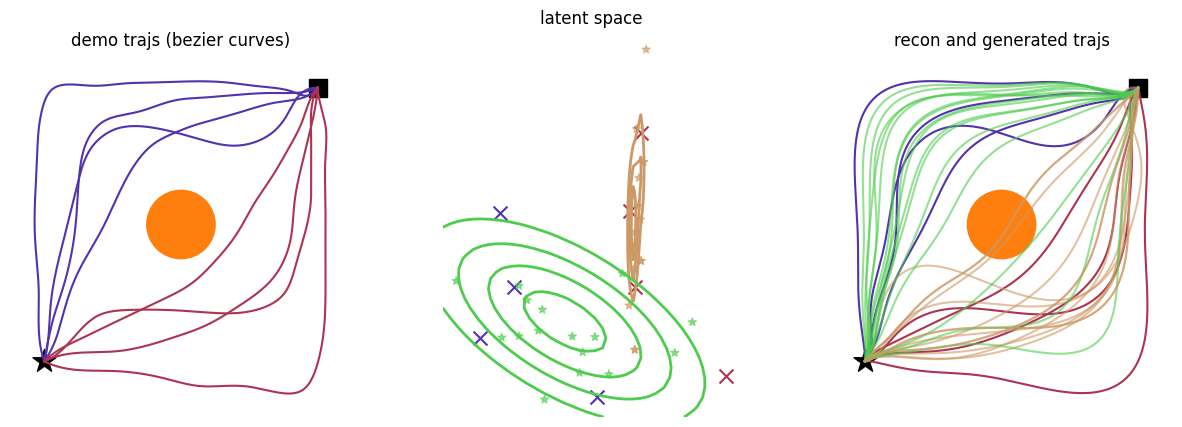

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

Z = best_ae.encode(params.to(device)).detach().cpu()

for i in [0, 2]:
    axs[i].set_xlim(workspace[0])
    axs[i].set_ylim(workspace[1])
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].scatter(init[0], init[1], marker='s', s=150, c='k')
    axs[i].scatter(goal[0], goal[1], marker='*', s=300, c='k')
    Obs = Circle(xy=[0,0], radius=0.2, color='tab:orange')
    axs[i].add_patch(Obs)
    if i == 0:
        for traj in trajs_class1:
            axs[i].plot(traj[:, 0], traj[:, 1], c=(0.2*np.array([0.8,0.2,0.2]) + (1-0.2)*np.array([0.2,0.2,0.8])).reshape(1, -1))
        for traj in trajs_class2:
            axs[i].plot(traj[:, 0], traj[:, 1], c=(0.8*np.array([0.8,0.2,0.2]) + (1-0.8)*np.array([0.2,0.2,0.8])).reshape(1, -1))

for i in range(len(Z)):
    c = 0.2 + 0.6*targets[i]
    axs[1].scatter(
        Z[i, 0], 
        Z[i, 1], 
        marker='x', 
        s=100, 
        c=(c*np.array([0.8,0.2,0.2]) + (1-c)*np.array([0.2,0.2,0.8])).reshape(1, -1)
        )

axs[1].set_aspect('equal')
axs[1].axis('off')

# gen_params= best_ae.decode(z_interp.view(len(z_interp), 1).to(device))
# gen_trajs = dmp2traj(gen_params, dof=2, num_points=500, T=5, dt=0.01).detach().cpu()

recon_params = best_ae.decode(Z.to(device))
gen_trajs = bezier2traj(recon_params, dof=2, traj_len=500, T=5).detach().cpu()

for i, traj in enumerate(gen_trajs):
    c = 0.2 + 0.6*targets[i].item()
    axs[2].plot(
        traj[:, 0], 
        traj[:, 1], 
        c=(c*np.array([0.8,0.2,0.2]) + (1-c)*np.array([0.2,0.2,0.8])).reshape(1, -1)
        , alpha=1
        )


## SAMPLING
num_calsses = 2
gm = GaussianMixture(n_components=num_calsses, random_state=0).fit(Z)
thr = gm.score_samples(Z).min()
    
sample_z = []
sample_y = []
num_samples = 0
while num_samples < 30:
    temp_z, temp_y = gm.sample(30)
    accept_idx = gm.score_samples(temp_z) > thr
    temp_y = temp_y[accept_idx]
    temp_z = temp_z[accept_idx]
    num_samples+=len(temp_z)
    sample_z.append(temp_z)
    sample_y.append(temp_y)
sample_z = np.concatenate(sample_z, axis=0)[:30]
sample_y = np.concatenate(sample_y, axis=0)[:30]

c = sample_y.reshape(-1,1)

axs[1].scatter(
    sample_z[:, 0], 
    sample_z[:, 1], 
    c=(c*np.array([[0.3,0.8,0.3]]) + (1-c)*np.array([[0.8,0.6,0.4]])).reshape(-1, 3), 
    marker='*', alpha=0.6)
        
sample_x = best_ae.decode(torch.tensor(sample_z, dtype=torch.float32).to(device))
sampled_trajs = bezier2traj(
    sample_x, 2, 5, traj_len=500).detach().cpu()
for traj, label in zip(sampled_trajs, sample_y):
    color = (label*np.array([[0.3,0.8,0.3]]) + (1-label)*np.array([[0.8,0.6,0.4]])).reshape(-1, 3)
    axs[2].plot(traj[:, 0], traj[:, 1], c=color, alpha=0.6)

mu = gm.means_
cov = gm.covariances_

xmin, xmax = axs[1].get_xbound()
ymin, ymax = axs[1].get_ybound()

for i, (mu, cov) in enumerate(zip(gm.means_, gm.covariances_)):
    tempZ = sample_z[sample_y == i]
    x = np.linspace(xmin, xmax, 40)
    y = np.linspace(ymin, ymax, 40)
    xx, yy = np.meshgrid(x, y) 
    delta = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1) - mu.reshape(1, -1)

    zz = np.exp(np.diagonal(
        -(delta@np.linalg.inv(cov)@delta.transpose())
    )/2)
    
    c = sample_y[sample_y == i].reshape(-1,1)
    contour = axs[1].contour(
        xx.reshape(40, 40), 
        yy.reshape(40, 40), 
        zz.reshape(40, 40),
        levels=[0.3, 0.5, 0.7, 0.9, 0.9999], 
        colors=(c*np.array([[0.3,0.8,0.3]]) + (1-c)*np.array([[0.8,0.6,0.4]])).reshape(-1, 3),
        linewidths=2,
        )

axs[0].set_title('demo trajs (bezier curves)')
axs[1].set_title('latent space')
axs[2].set_title('recon and generated trajs')

plt.show()

## IRAE

In [13]:
encoder = FC_vec(
    in_chan=num_control_points*2,
    out_chan=2,
    l_hidden=[256, 256, 256, 256],
    activation=['elu', 'elu', 'elu', 'elu'],
    out_activation='linear'
)
decoder = FC_vec(
    in_chan=2,
    out_chan=num_control_points*2,
    l_hidden=[256, 256, 256, 256],
    activation=['elu', 'elu', 'elu', 'elu'],
    out_activation='linear'
)
ae = IRAE(encoder=encoder, decoder=decoder, init_final_projection=True, dim=2, metric='bezier', T=5, num_control_points=num_control_points, iso_reg=0.1)
ae.to(device);

In [14]:
optimizer = torch.optim.Adam(ae.parameters(), lr=0.0001)

best_recon = torch.inf
for epoch in range(1000):
    loss = ae.train_step(params.squeeze(-1).to(device), optimizer)
    if epoch%50 == 0:
        loss = loss['loss']
        recon = ae.validation_step(params.squeeze(-1).to(device))['loss']
        if recon < best_recon:
            best_ae = copy.copy(ae)
            best_recon = recon
            print(f'best_model_copied: {recon} < {best_recon}')
        print(f'{epoch}, total_loss: {loss}, recon_loss: {recon}')

best_model_copied: 1.353669285774231 < 1.353669285774231
0, total_loss: 1.4093148708343506, recon_loss: 1.353669285774231
best_model_copied: 0.34445688128471375 < 0.34445688128471375
50, total_loss: 0.44630640745162964, recon_loss: 0.34445688128471375
best_model_copied: 0.0617351233959198 < 0.0617351233959198
100, total_loss: 0.15053489804267883, recon_loss: 0.0617351233959198
best_model_copied: 0.02756231650710106 < 0.02756231650710106
150, total_loss: 0.07221929728984833, recon_loss: 0.02756231650710106
best_model_copied: 0.017987685278058052 < 0.017987685278058052
200, total_loss: 0.046053383499383926, recon_loss: 0.017987685278058052
best_model_copied: 0.012453963980078697 < 0.012453963980078697
250, total_loss: 0.04778538644313812, recon_loss: 0.012453963980078697
best_model_copied: 0.01050470769405365 < 0.01050470769405365
300, total_loss: 0.08290064334869385, recon_loss: 0.01050470769405365
best_model_copied: 0.00860462337732315 < 0.00860462337732315
350, total_loss: 0.108611792

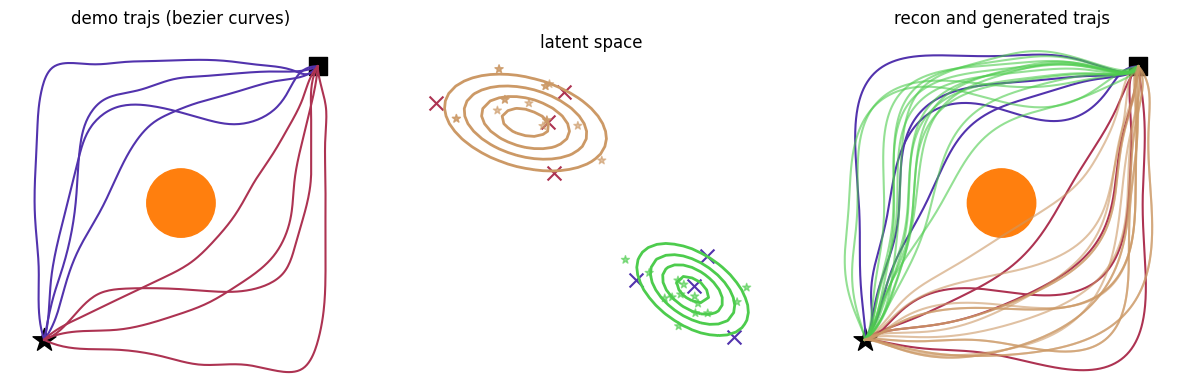

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

Z = best_ae.encode(params.to(device)).detach().cpu()

for i in [0, 2]:
    axs[i].set_xlim(workspace[0])
    axs[i].set_ylim(workspace[1])
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].scatter(init[0], init[1], marker='s', s=150, c='k')
    axs[i].scatter(goal[0], goal[1], marker='*', s=300, c='k')
    Obs = Circle(xy=[0,0], radius=0.2, color='tab:orange')
    axs[i].add_patch(Obs)
    if i == 0:
        for traj in trajs_class1:
            axs[i].plot(traj[:, 0], traj[:, 1], c=(0.2*np.array([0.8,0.2,0.2]) + (1-0.2)*np.array([0.2,0.2,0.8])).reshape(1, -1))
        for traj in trajs_class2:
            axs[i].plot(traj[:, 0], traj[:, 1], c=(0.8*np.array([0.8,0.2,0.2]) + (1-0.8)*np.array([0.2,0.2,0.8])).reshape(1, -1))

for i in range(len(Z)):
    c = 0.2 + 0.6*targets[i]
    axs[1].scatter(
        Z[i, 0], 
        Z[i, 1], 
        marker='x', 
        s=100, 
        c=(c*np.array([0.8,0.2,0.2]) + (1-c)*np.array([0.2,0.2,0.8])).reshape(1, -1)
        )

axs[1].set_aspect('equal')
axs[1].axis('off')

# gen_params= best_ae.decode(z_interp.view(len(z_interp), 1).to(device))
# gen_trajs = dmp2traj(gen_params, dof=2, num_points=500, T=5, dt=0.01).detach().cpu()

recon_params = best_ae.decode(Z.to(device))
gen_trajs = bezier2traj(recon_params, dof=2, traj_len=500, T=5).detach().cpu()

for i, traj in enumerate(gen_trajs):
    c = 0.2 + 0.6*targets[i].item()
    axs[2].plot(
        traj[:, 0], 
        traj[:, 1], 
        c=(c*np.array([0.8,0.2,0.2]) + (1-c)*np.array([0.2,0.2,0.8])).reshape(1, -1)
        , alpha=1
        )


## SAMPLING
num_calsses = 2
gm = GaussianMixture(n_components=num_calsses, random_state=0).fit(Z)
thr = gm.score_samples(Z).min()
    
sample_z = []
sample_y = []
num_samples = 0
while num_samples < 30:
    temp_z, temp_y = gm.sample(30)
    accept_idx = gm.score_samples(temp_z) > thr
    temp_y = temp_y[accept_idx]
    temp_z = temp_z[accept_idx]
    num_samples+=len(temp_z)
    sample_z.append(temp_z)
    sample_y.append(temp_y)
sample_z = np.concatenate(sample_z, axis=0)[:30]
sample_y = np.concatenate(sample_y, axis=0)[:30]

c = sample_y.reshape(-1,1)
axs[1].scatter(
    sample_z[:, 0], 
    sample_z[:, 1], 
    c=(c*np.array([[0.3,0.8,0.3]]) + (1-c)*np.array([[0.8,0.6,0.4]])).reshape(-1, 3), 
    marker='*', alpha=0.6)
        
sample_x = best_ae.decode(torch.tensor(sample_z, dtype=torch.float32).to(device))
sampled_trajs = bezier2traj(
    sample_x, 2, 5, traj_len=500).detach().cpu()
for traj, label in zip(sampled_trajs, sample_y):
    color = (label*np.array([[0.3,0.8,0.3]]) + (1-label)*np.array([[0.8,0.6,0.4]])).reshape(-1, 3)
    axs[2].plot(traj[:, 0], traj[:, 1], c=color, alpha=0.6)

mu = gm.means_
cov = gm.covariances_

xmin, xmax = axs[1].get_xbound()
ymin, ymax = axs[1].get_ybound()

for i, (mu, cov) in enumerate(zip(gm.means_, gm.covariances_)):
    tempZ = sample_z[sample_y == i]
    x = np.linspace(xmin, xmax, 40)
    y = np.linspace(ymin, ymax, 40)
    xx, yy = np.meshgrid(x, y) 
    delta = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1) - mu.reshape(1, -1)

    zz = np.exp(np.diagonal(
        -(delta@np.linalg.inv(cov)@delta.transpose())
    )/2)
    
    c = sample_y[sample_y == i].reshape(-1,1)
    contour = axs[1].contour(
        xx.reshape(40, 40), 
        yy.reshape(40, 40), 
        zz.reshape(40, 40),
        levels=[0.3, 0.5, 0.7, 0.9, 0.9999], 
        colors=(c*np.array([[0.3,0.8,0.3]]) + (1-c)*np.array([[0.8,0.6,0.4]])).reshape(-1, 3),
        linewidths=2,
        )

axs[0].set_title('demo trajs (bezier curves)')
axs[1].set_title('latent space')
axs[2].set_title('recon and generated trajs')

plt.show()